In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from scipy.stats import linregress
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [82]:
!ls

IR-data.xlsx        README.md           Vasicek-model.ipynb


In [111]:
ir = pd.read_excel('IR-data.xlsx')
ir['delta'] = ir['Interest rate'].diff()
# ir.loc[:, ['Interest rate', 'delta']] = ir.loc[:, ['Interest rate', 'delta']].multiply(0.01)
ir = ir.rename(columns={'Interest rate': 'interest_rate'})
# ir = ir.bfill()
ir = ir.dropna()
ir

,Date,interest_rate,delta
1,2011-01-06,4.13,-0.07
2,2011-01-13,4.08,-0.05
3,2011-01-20,4.05,-0.03
4,2011-01-27,4.09,0.04
5,2011-02-03,4.08,-0.01
...,...,...,...
582,2022-02-24,3.14,-0.01
583,2022-03-03,3.01,-0.13
584,2022-03-10,3.09,0.08
585,2022-03-17,3.39,0.30


In [112]:
train = ir.loc[ir['Date'] < '2021-01-01', :]
test = ir.loc[ir['Date'] >= '2021-01-01', :]

# x_train = sm.add_constant(train['interest_rate'])
x_train = train.loc[:, 'interest_rate']
y_train = train['delta']

# x_test = sm.add_constant(test['interest_rate'])
x_test = test.loc[:, 'interest_rate']
y_test = test['delta']

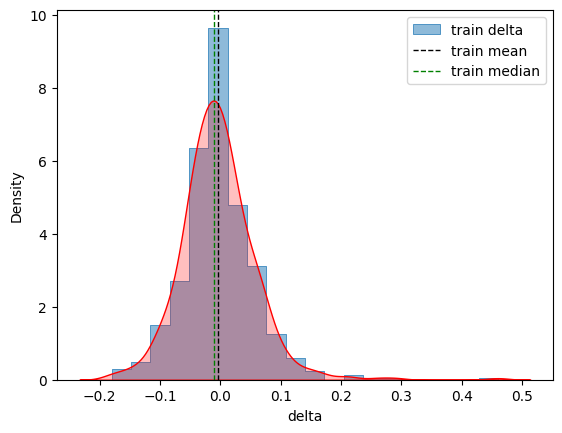

In [113]:
hist = sns.histplot(y_train, bins=20, alpha=0.5, label='train delta', stat='density', common_norm=False, element='step', fill=True, linewidth=0.5)
# add KDE
sns.kdeplot(y_train, color='red', linewidth=1, fill=True)

plt.axvline(y_train.mean(), color='black', linestyle='dashed', linewidth=1, label='train mean')
plt.axvline(y_train.median(), color='green', linestyle='dashed', linewidth=1, label='train median')

plt.legend()
plt.show()

In [129]:
linreg = smf.ols('delta ~ interest_rate', data=train).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  delta   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.016
Date:                Sun, 25 Aug 2024   Prob (F-statistic):             0.0830
Time:                        21:09:06   Log-Likelihood:                 709.30
No. Observations:                 522   AIC:                            -1415.
Df Residuals:                     520   BIC:                            -1406.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0380      0.020     -1.916      0.056      -0.077       0.001
interest_rate     0.0106      0.006      1.737      0.083      -0.001       0.023
==============================================================================
Omnibus:                      167.030   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1221.188
Skew:                           1.195   Prob(JB):                    6.64e-266
Kurtosis:                      10.102   Cond. No.                         25.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [121]:
a_value = linreg.params[1]
b_value = -1 * linreg.params[0] / a_value
ir_t = x_train.values[-1] # last value of interest rate on training set
linreg_mse = linreg.mse_resid # MSE for Residuals / Variance for the model
print(f' a: {a_value} \n b: {b_value} \n σ: {linreg_mse} \n last training data interest rate: {ir_t}')

 a: 0.010578276031442423 
 b: 3.5958481328655654 
 σ: 0.0038809611761610806 
 last training data interest rate: 2.17


In [122]:
# forecasting with Vasicek model formula
vasicek_pred = []
for day in tqdm(range(len(test))):
    new_ir = ir_t * np.exp(-1 * a_value * day) + b_value * (1 - np.exp(-1 * a_value * day))
    new_var = (1 - np.exp(-2 * a_value * day)) * linreg_mse ** 2 / (2 * a_value)
    vasicek_pred.append([new_ir, new_var])

vasicek_pred_df = pd.DataFrame(vasicek_pred, columns=['interest_rate', 'variance'])
vasicek_pred_df['Date'] = test['Date'].values
vasicek_pred_df = vasicek_pred_df[['Date', 'interest_rate', 'variance']]
vasicek_pred_df

100%|██████████| 64/64 [00:00<00:00, 73483.56it/s]


,Date,interest_rate,variance
0,2021-01-07,2.170000,0.000000
1,2021-01-14,2.185004,0.000015
2,2021-01-21,2.199849,0.000029
3,2021-01-28,2.214539,0.000044
4,2021-02-04,2.229073,0.000058
...,...,...,...
59,2022-02-24,2.831973,0.000508
60,2022-03-03,2.840011,0.000512
61,2022-03-10,2.847965,0.000516
62,2022-03-17,2.855834,0.000520


In [123]:
# long run forecast
ir_long = b_value
vol_long = linreg_mse / (2 * a_value)
print(f'Long run interest rate: {ir_long} \nLong run variance: {vol_long}')

Long run interest rate: 3.5958481328655654 
Long run variance: 0.18344015436095043


In [124]:
# OLS Prediction / forecasting with linear regression model
pred = linreg.predict(x_test)
linreg_mse = np.mean((pred - y_test) ** 2)
pred, linreg_mse, linreg.rsquared

(523   -0.015189
 524   -0.014448
 525   -0.014660
 526   -0.014766
 527   -0.014660
          ...   
 582   -0.004822
 583   -0.006197
 584   -0.005351
 585   -0.002178
 586    0.000361
 Length: 64, dtype: float64,
 0.007568070915841457,
 0.005766928718741293)

In [125]:
ir4ols = ir.loc[len(train) - 1:, ['Date', 'interest_rate']]
ir4ols['interest_rate'] = ir4ols['interest_rate'].shift(1)
ir4ols.loc[:, 'interest_rate'] = ir4ols.loc[:, 'interest_rate'] + pred.values[1]
ir4ols = ir4ols.dropna()
ir4ols

,Date,interest_rate
522,2020-12-31,2.175552
523,2021-01-07,2.155552
524,2021-01-14,2.145552
525,2021-01-21,2.215552
526,2021-01-28,2.195552
...,...,...
582,2022-02-24,3.135552
583,2022-03-03,3.125552
584,2022-03-10,2.995552
585,2022-03-17,3.075552


In [126]:
ols_vasicek = pd.merge(ir4ols, vasicek_pred_df, on='Date', suffixes=('_ols', '_vasicek'))
ols_vasicek

,Date,interest_rate_ols,interest_rate_vasicek,variance
0,2021-01-07,2.155552,2.170000,0.000000
1,2021-01-14,2.145552,2.185004,0.000015
2,2021-01-21,2.215552,2.199849,0.000029
3,2021-01-28,2.195552,2.214539,0.000044
4,2021-02-04,2.185552,2.229073,0.000058
...,...,...,...,...
59,2022-02-24,3.135552,2.831973,0.000508
60,2022-03-03,3.125552,2.840011,0.000512
61,2022-03-10,2.995552,2.847965,0.000516
62,2022-03-17,3.075552,2.855834,0.000520


In [127]:
mse = np.mean((ols_vasicek['interest_rate_ols'] - ols_vasicek['interest_rate_vasicek']) ** 2)
mse

0.09013479164179791